In [1]:
#set up packages
import pandas as pd
import numpy as np
import plotly as plt
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as mplt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

In [2]:
# set up library
from plotnine import *
from mizani.formatters import percent_format

In [6]:
#import csv with comment data

# Read CSV into Pandas DataFrame
df =  pd.read_csv('../data/final_data.csv')

In [7]:
df.head()

Unnamed: 0.1  Unnamed: 0                         game     video_id  \
0             0         502   Group Stage USA vs Vietnam  mg5R3CnlFeM   
1             1         506   Group Stage USA vs Vietnam  mg5R3CnlFeM   
2             2         507   Group Stage USA vs Vietnam  mg5R3CnlFeM   
3             3         508   Group Stage USA vs Vietnam  mg5R3CnlFeM   
4             4         509   Group Stage USA vs Vietnam  mg5R3CnlFeM   

   comment_like_count                                               text  \
0                   0  it's been a while since I've been happy merced...   
1                   0     It's shocking how bad these teams actually are   
2                   0         USA Wohoooooo  good begInning girls !! 👏 👏   
3                   0  What Vietnam needs is to have those Vietnamese...   
4                   0  Repent to Jesus Christ “Make sure that nobody ...   

   reply_count             comment_date  \
0          0.0  2023-07-22 17:52:55 UTC   
1          0.0  2023-07-22 17:45:09 UTC   
2          0.0  2023-07-22 17:43:44 UTC   
3          0.0  2023-07-22 17:41:35 UTC   
4          0.0  2023-07-22 17:37:59 UTC   

                                         text_string  \
0  it's been a while since I've been happy merced...   
1     It's shocking how bad these teams actually are   
2         USA Wohoooooo  good begInning girls !! 👏 👏   
3  What Vietnam needs is to have those Vietnamese...   
4  Repent to Jesus Christ “Make sure that nobody ...   

                                    roberta_hs_score  roberta_label  \
0  [{'label': 'nothate', 'score': 0.99985671043396}]              0   
1  [{'label': 'nothate', 'score': 0.9998511075973...              0   
2    [{'label': 'hate', 'score': 0.765491247177124}]              1   
3   [{'label': 'hate', 'score': 0.9989185333251953}]              1   
4  [{'label': 'nothate', 'score': 0.9908456206321...              0   

   roberta_score                                 perspective_scores  
0       0.999857  {'TOXICITY': 0.08716487, 'IDENTITY_ATTACK': 0....  
1       0.999851  {'TOXICITY': 0.20056234, 'IDENTITY_ATTACK': 0....  
2       0.765491  {'TOXICITY': 0.031213367, 'IDENTITY_ATTACK': 0...  
3       0.998919  {'TOXICITY': 0.08637348, 'IDENTITY_ATTACK': 0....  
4       0.990846  {'TOXICITY': 0.0126288915, 'IDENTITY_ATTACK': ...

In [8]:
# Create Category
df['hate_category'] = np.where(df['roberta_label']== 1, "Hate", "Not Hate")

In [9]:
# reformat dates
df['comment_date'] = pd.to_datetime(df['comment_date']).dt.strftime('%Y-%m-%d')
# order games
game_order = [' Group Stage USA vs Vietnam', ' Group Stage USA vs Netherlands', ' Group Stage USA vs Portugal', ' Round of 16 USA vs Sweden']
df['games_ordered'] = pd.Categorical(df['game'], categories=game_order, ordered=True)

# Visualization of Comments by Hate/Not Hate

In [10]:
# calculate proportion of comments by game
total_comments_share = pd.crosstab(
    index=[df['games_ordered']],
    columns=df['roberta_label'],
    normalize='index',
    margins=False
)

total_comments_share = total_comments_share.reset_index()

# rename columns
total_comments_share.columns = ['games_ordered', 'share_not_hate', 'share_hate']
total_comments_share.head()

games_ordered  share_not_hate  share_hate
0       Group Stage USA vs Vietnam        0.871536    0.128464
1   Group Stage USA vs Netherlands        0.903264    0.096736
2      Group Stage USA vs Portugal        0.902308    0.097692
3        Round of 16 USA vs Sweden        0.859911    0.140089

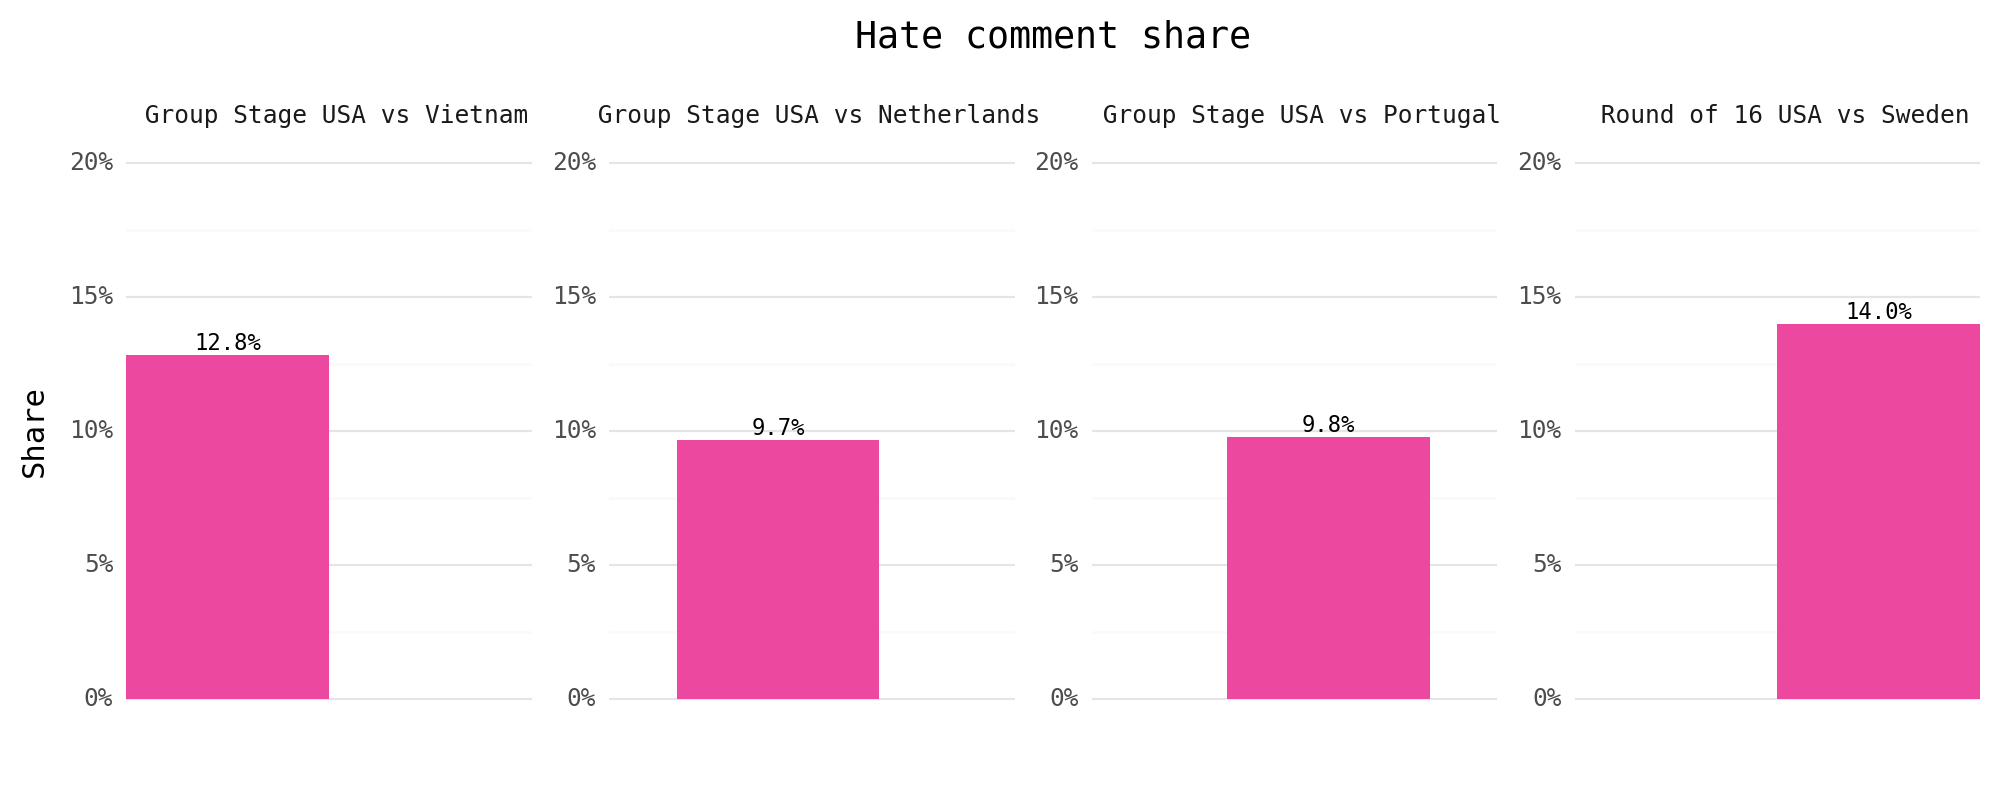

In [11]:
# plot hate comment share by game

total_share_plot_1 = (
    ggplot(total_comments_share, aes(x='games_ordered', y='share_hate', label = 'share_hate')) +
    geom_bar(stat='identity', width = 3, fill='#ed48a0') +
    facet_wrap('~games_ordered', scales='free_y', nrow = 1) +  # One row for each game
    labs(title='Hate comment share', x='', y='Share') +
    #scale_fill_discrete(labels = ['Hate', 'Not Hate']) +
    scale_y_continuous(labels=percent_format(),  limits=(0, 0.2)) +
    geom_text(position=position_dodge(width = 3), size=8, va='bottom', format_string='{:.1%}') +
    #geom_text(aes(label= 'share', group = 'comment_type'), position = 'dodge', format_string='{:.1%}') +
    theme_minimal() +
    theme(figure_size=(10,4), axis_text_x=element_blank(), text=element_text(family='monospace'),
          plot_title=element_text(hjust=0.5, family = 'monospace'), panel_grid_major_x= element_blank(),
          legend_title=element_blank())
)

print(total_share_plot_1)

In [12]:
# pivot table for comment classification counts
#total_comments_count = total_comments.pivot(index='games_ordered', columns='label', values='total_comments').fillna(0)
total_comments_count = pd.crosstab(
    index=[df['games_ordered']],
    columns=df['roberta_label'],
    margins=False
)

total_comments_count = total_comments_count.reset_index()
total_comments_count.columns = ['games_ordered', 'Not_Hate', 'Hate']
# Fix order of columns
total_comments_count = total_comments_count[['games_ordered', 'Hate', 'Not_Hate']]
total_comments_count.head()

games_ordered  Hate  Not_Hate
0       Group Stage USA vs Vietnam  1604     10882
1   Group Stage USA vs Netherlands  2395     22363
2      Group Stage USA vs Portugal  1109     10243
3        Round of 16 USA vs Sweden  3181     19526

In [13]:
total_comments_share = pd.melt(total_comments_share, id_vars=['games_ordered'], value_vars=['share_not_hate', 'share_hate'],
                    var_name='comment_type', value_name='share')
total_comments_share.head()

games_ordered    comment_type     share
0       Group Stage USA vs Vietnam  share_not_hate  0.871536
1   Group Stage USA vs Netherlands  share_not_hate  0.903264
2      Group Stage USA vs Portugal  share_not_hate  0.902308
3        Round of 16 USA vs Sweden  share_not_hate  0.859911
4       Group Stage USA vs Vietnam      share_hate  0.128464

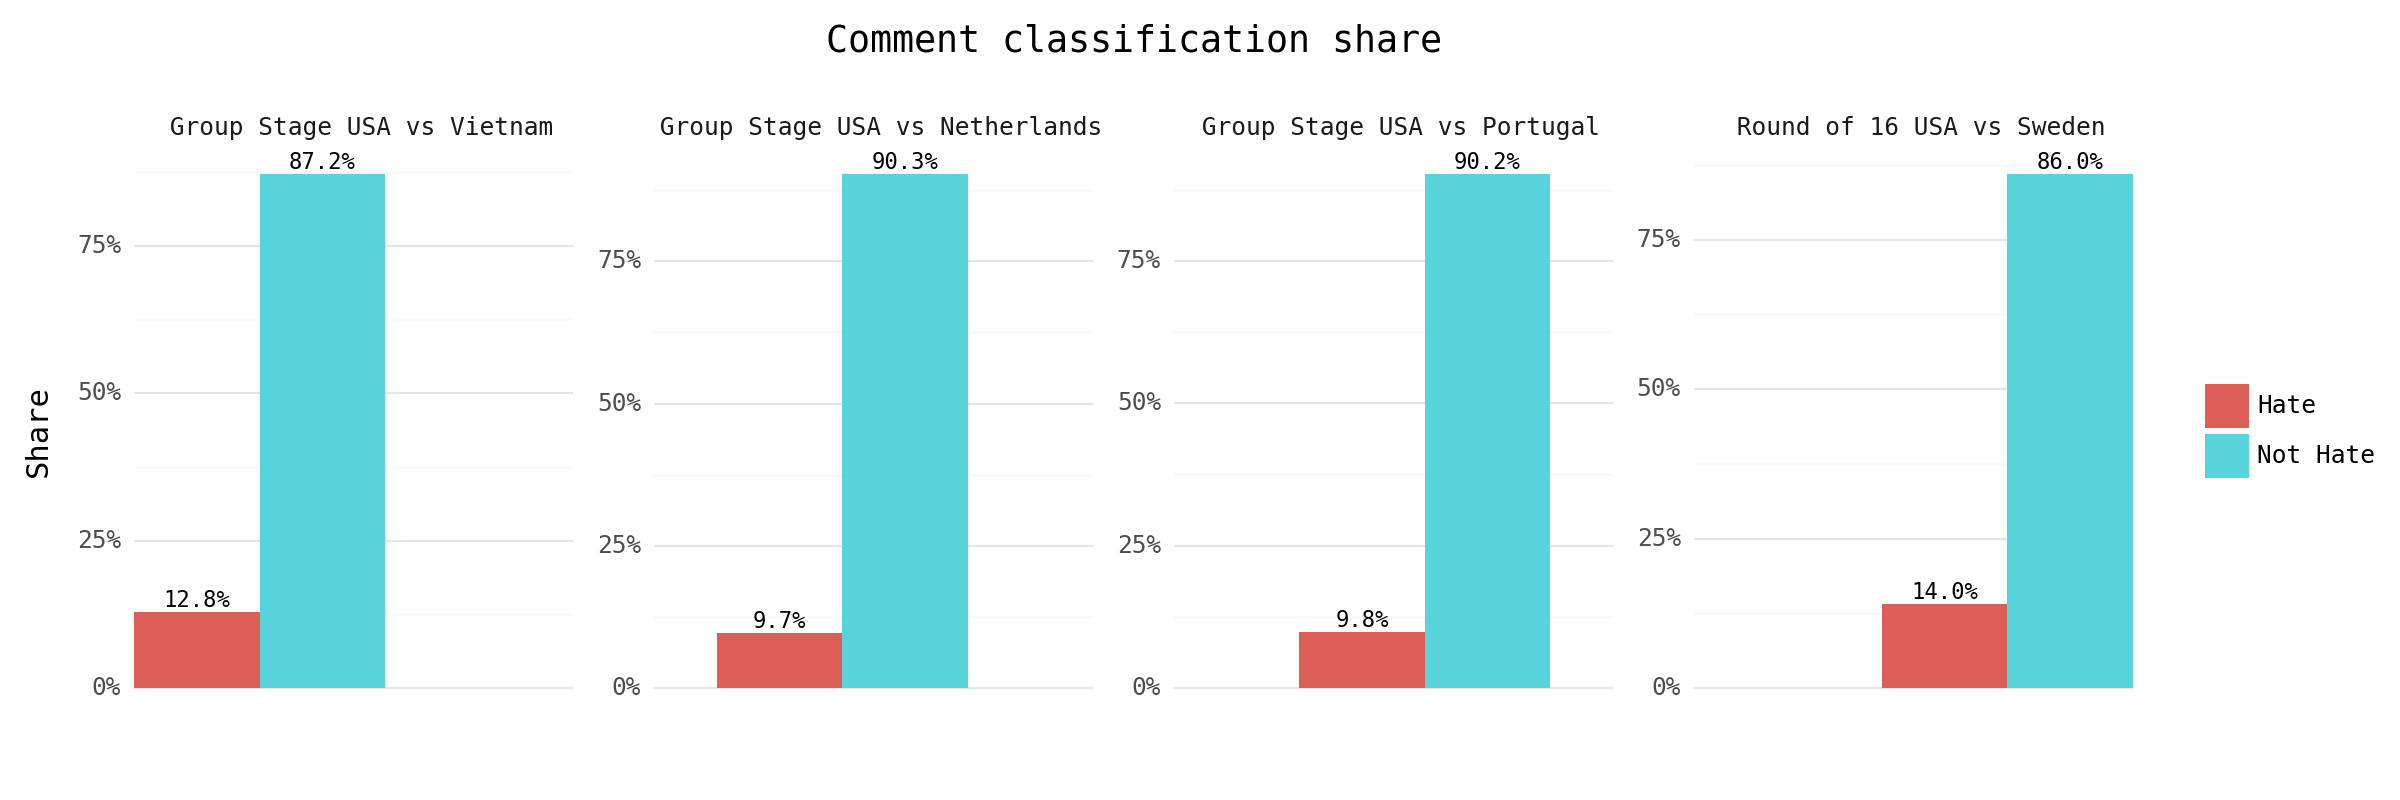

In [14]:
# plot bar chart of comment classification share by game
total_share_plot = (
    ggplot(total_comments_share, aes(x='games_ordered', y='share', fill='comment_type', label = 'share')) +
    geom_bar(stat='identity', position='dodge', width = 4) +
    facet_wrap('~games_ordered', scales='free_y', nrow = 1) +  # One row for each game
    labs(title='Comment classification share', x='', y='Share') +
    scale_fill_discrete(labels = ['Hate', 'Not Hate']) +
    scale_y_continuous(labels=percent_format()) +
    geom_text(position=position_dodge(width = 4), size=8, va='bottom', format_string='{:.1%}') +
    #geom_text(aes(label= 'share', group = 'comment_type'), position = 'dodge', format_string='{:.1%}') +
    theme_minimal() +
    theme(figure_size=(12,4), axis_text_x=element_blank(), text=element_text(family='monospace'),
          plot_title=element_text(hjust=0.5, family = 'monospace'), panel_grid_major_x= element_blank(),
          legend_title=element_blank())
)

print(total_share_plot)

In [15]:
# calculate comment category counts for each game

total_comments = df.groupby(['games_ordered', 'roberta_label']).size().reset_index(name='total_comments')

# add label
total_comments['label'] = total_comments['roberta_label'].replace({0: 'Not Hate', 1: 'Hate'})
total_comments

games_ordered  roberta_label  total_comments     label
0       Group Stage USA vs Vietnam              0           10882  Not Hate
1       Group Stage USA vs Vietnam              1            1604      Hate
2   Group Stage USA vs Netherlands              0           22363  Not Hate
3   Group Stage USA vs Netherlands              1            2395      Hate
4      Group Stage USA vs Portugal              0           10243  Not Hate
5      Group Stage USA vs Portugal              1            1109      Hate
6        Round of 16 USA vs Sweden              0           19526  Not Hate
7        Round of 16 USA vs Sweden              1            3181      Hate

/Users/aasthajha/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_bar : Removed 1 rows containing missing values.
/Users/aasthajha/anaconda3/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 1 rows containing missing values.


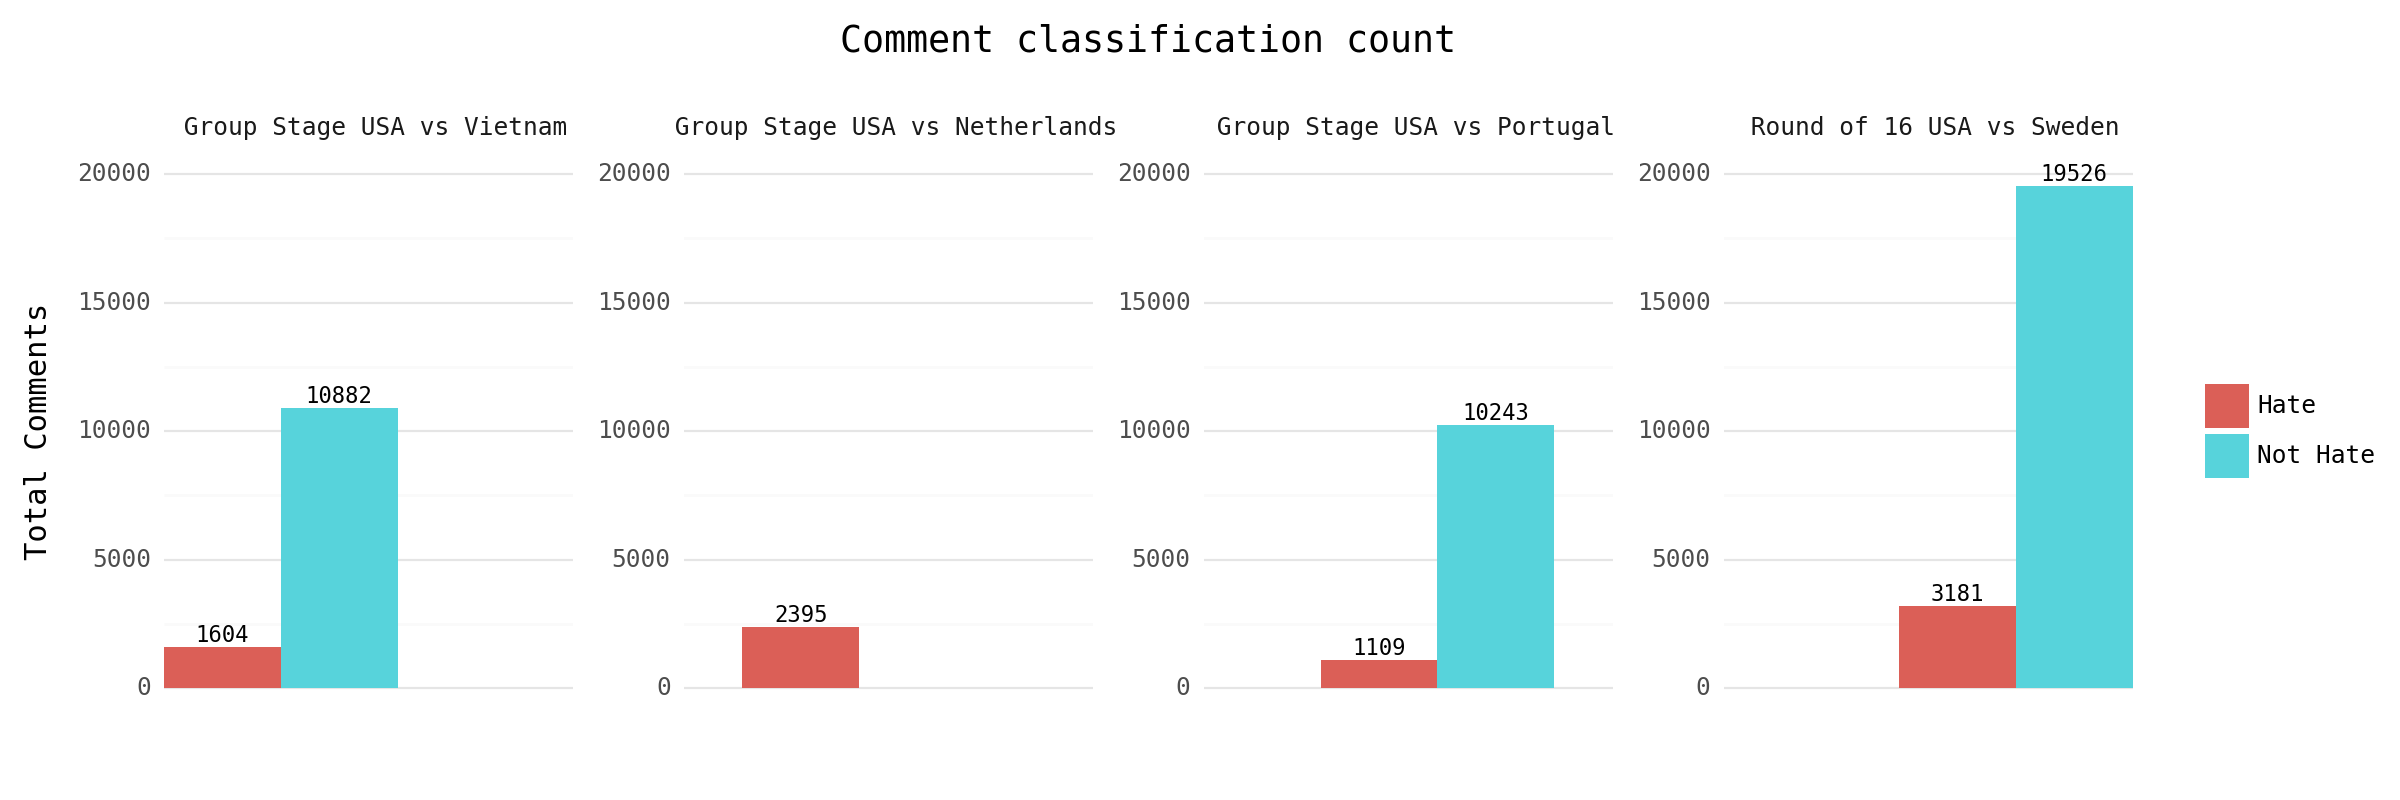

In [16]:
# plot classification count by game
total_comments_plot = (
    ggplot(total_comments, aes(x='games_ordered', y='total_comments', fill='label', label = 'total_comments')) +
    geom_bar(stat='identity', position='dodge', width=4) +
    geom_text(position=position_dodge(width = 4), size=8, va='bottom') +
    facet_wrap('~games_ordered', scales='free_y', nrow=1) +
    scale_y_continuous(limits=(0, 20000)) +
    labs(title='Comment classification count', x='', y='Total Comments') +
    theme_minimal() +
    theme(
        figure_size=(12, 4),
        axis_text_x=element_blank(),
        text=element_text(family='monospace'),
        plot_title=element_text(hjust=0.5, family='monospace'),
        panel_grid_major_x=element_blank(),
        legend_title=element_blank()
    )
)

print(total_comments_plot)

In [17]:
# pivot table for comment classification counts
#total_comments_count = total_comments.pivot(index='games_ordered', columns='label', values='total_comments').fillna(0)
total_comments_count = pd.crosstab(
    index=[df['games_ordered']],
    columns=df['roberta_label'],
    margins=False
)

total_comments_count = total_comments_count.reset_index()
total_comments_count.columns = ['games_ordered', 'Not_Hate', 'Hate']
# Fix order of columns
total_comments_count = total_comments_count[['games_ordered', 'Hate', 'Not_Hate']]
total_comments_count.head()

games_ordered  Hate  Not_Hate
0       Group Stage USA vs Vietnam  1604     10882
1   Group Stage USA vs Netherlands  2395     22363
2      Group Stage USA vs Portugal  1109     10243
3        Round of 16 USA vs Sweden  3181     19526

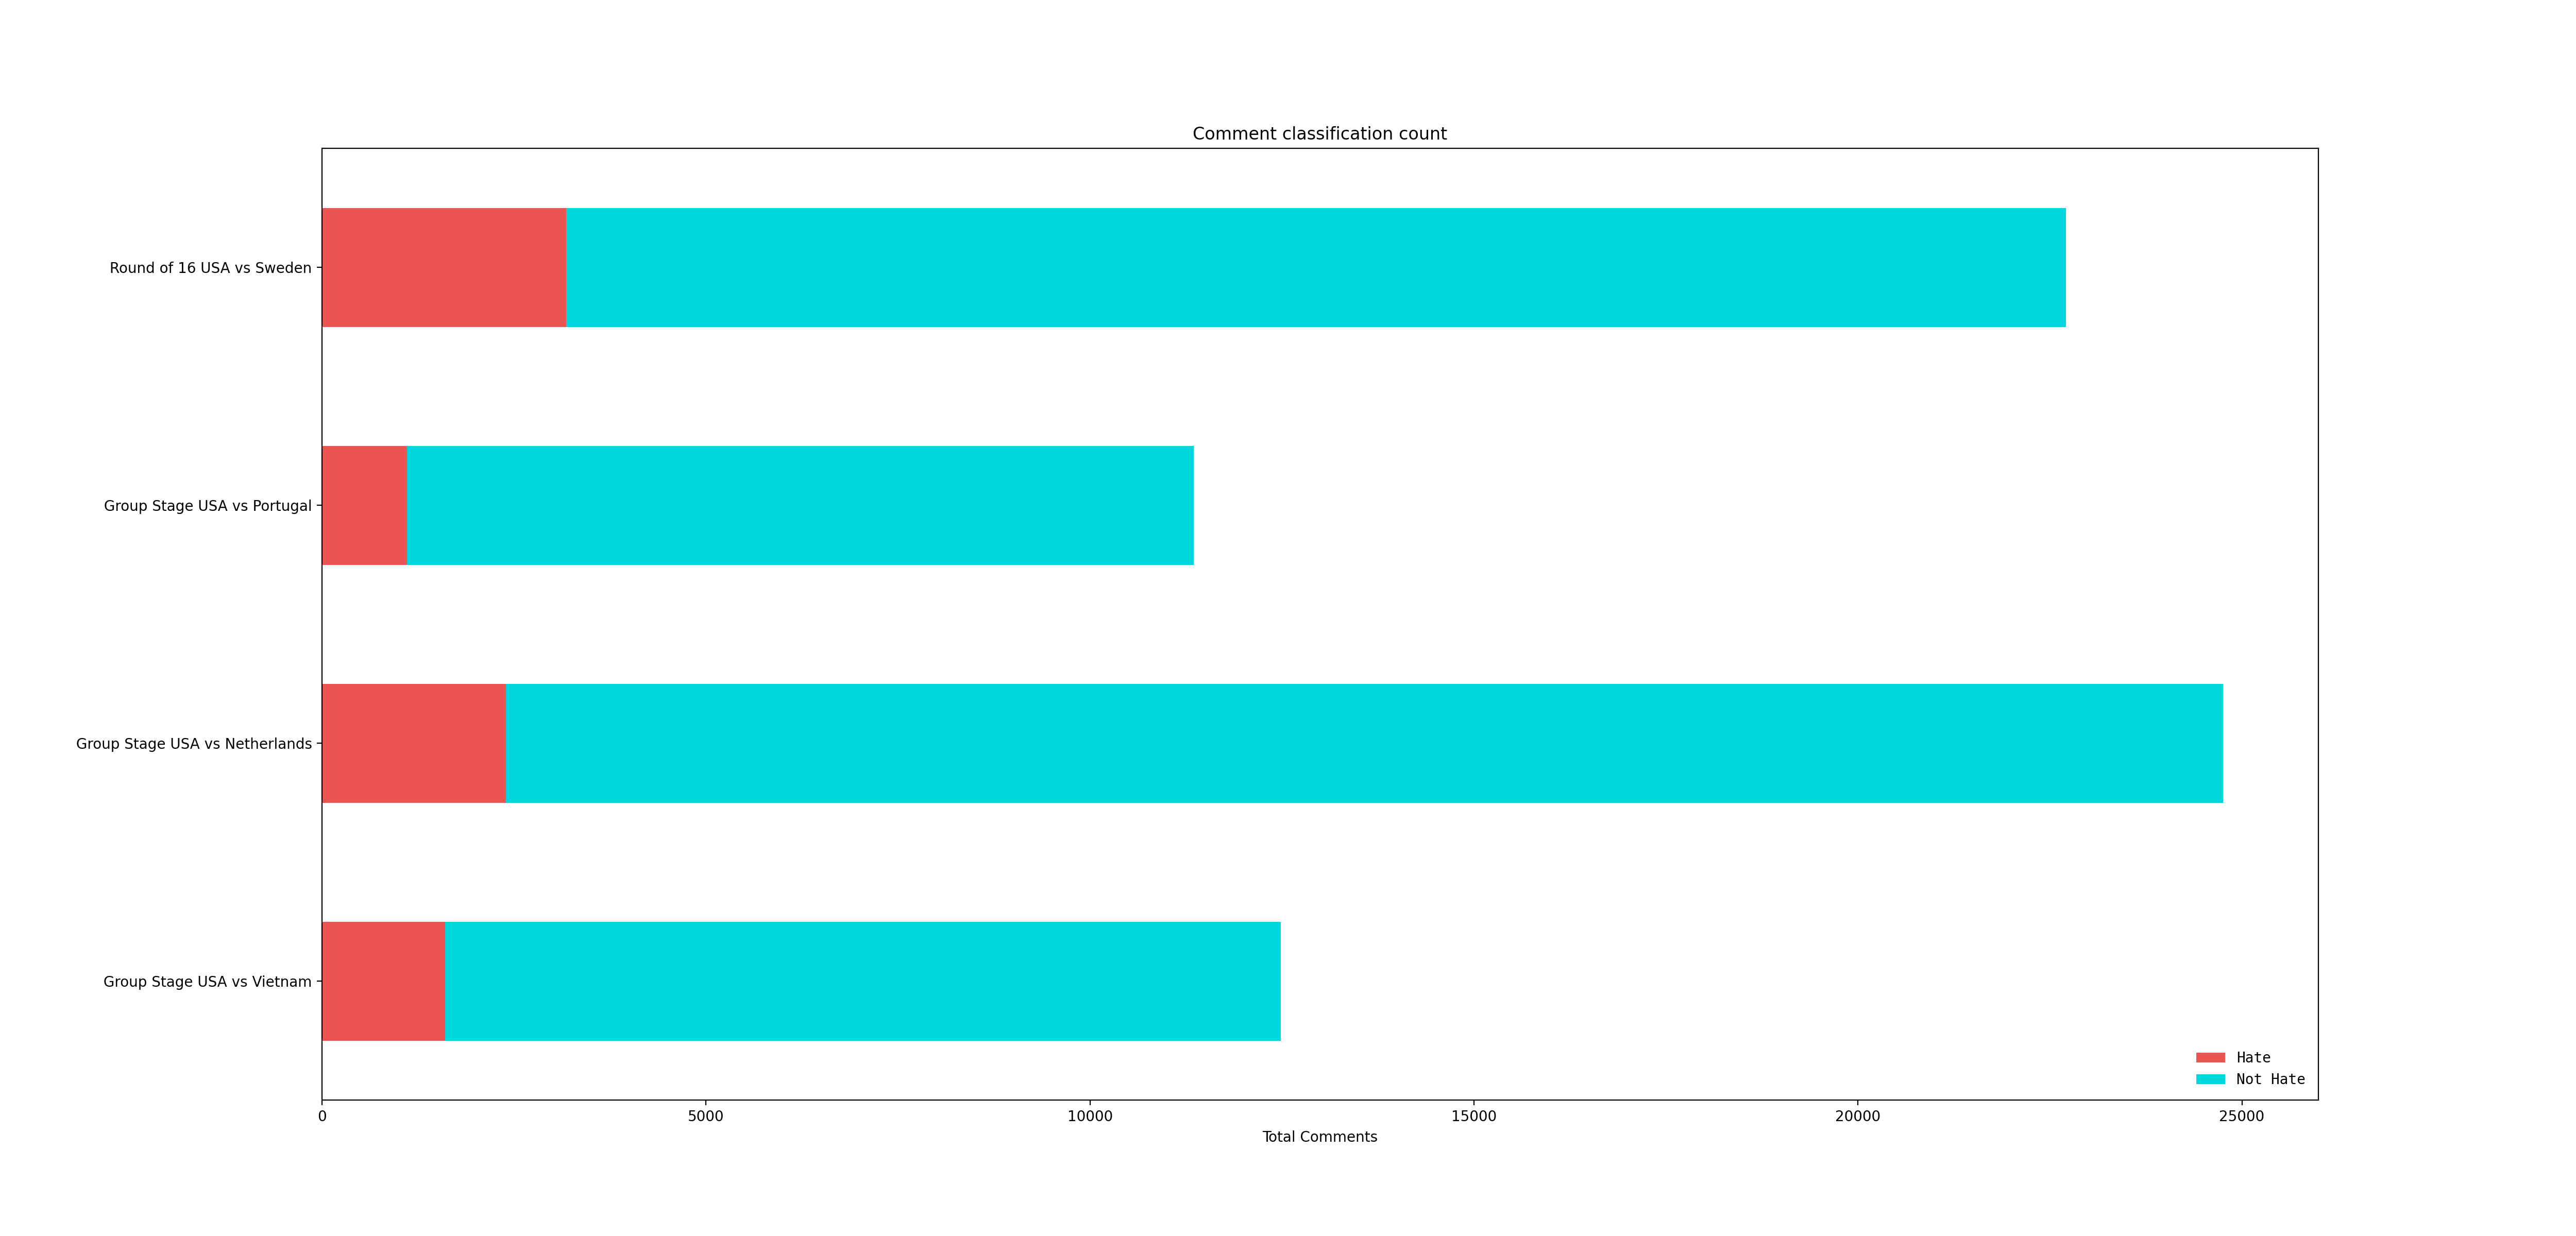

In [18]:
# Create a stacked bar plot
fig, ax = mplt.subplots(figsize=(25,12), facecolor='white')

total_comments_count.plot(kind='barh', stacked=True, ax=ax, color=['#ec5451', '#00d6dd'])

# Set font to monospace
mplt.rcParams["font.family"] = "monospace"
mplt.rcParams['figure.dpi']= 300

# Set plot labels and title
ax.set_title('Comment classification count')
ax.set_xlabel('Total Comments')
ax.set_ylabel('')
ax.set_yticklabels(total_comments_count.games_ordered)

# Remove y-axis grid lines
ax.yaxis.grid(False)

# Create a legend
ax.legend(title='', loc='lower right', frameon = False, labels = ["Hate", "Not Hate"])
mplt.show()

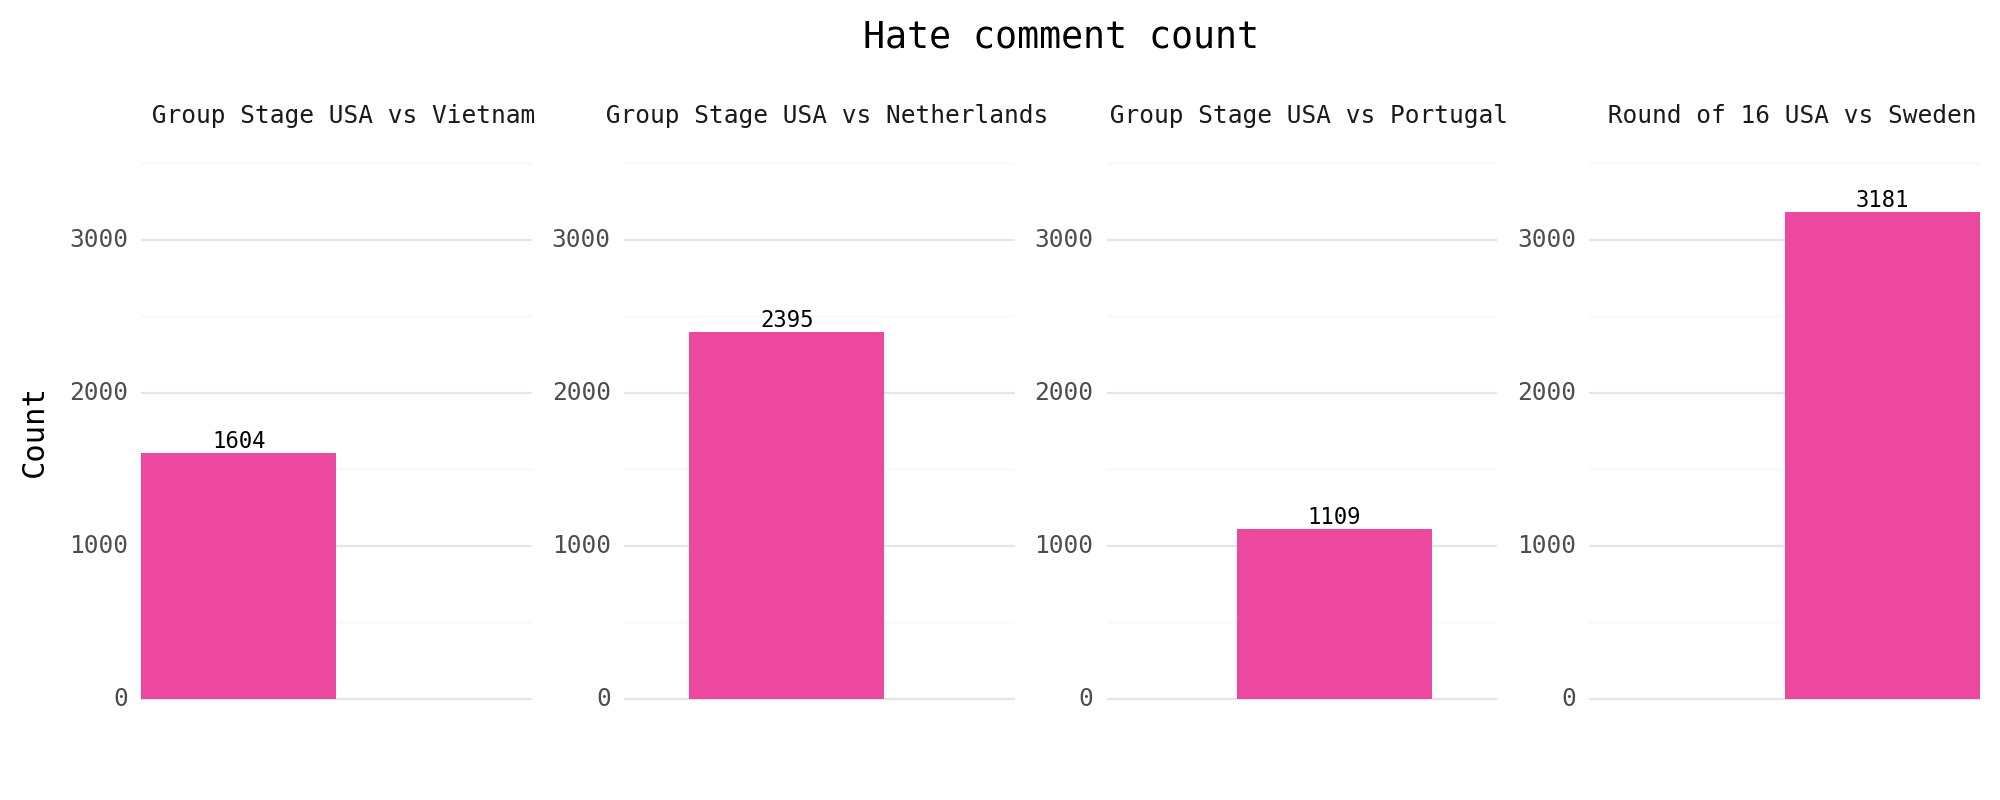

In [19]:
# plot hate comment count by game
total_count_plot_1 = (
    ggplot(total_comments_count, aes(x='games_ordered', y='Hate', label = 'Hate')) +
    geom_bar(stat='identity', width = 3, fill='#ed48a0') +
    facet_wrap('~games_ordered', scales='free_y', nrow = 1) +  # One row for each game
    labs(title='Hate comment count', x='', y='Count') +
    #scale_fill_discrete(labels = ['Hate', 'Not Hate']) +
    scale_y_continuous(limits=(0, 3500)) +
    geom_text(position=position_dodge(width = 3), size=8, va='bottom') +
    #geom_text(aes(label= 'share', group = 'comment_type'), position = 'dodge', format_string='{:.1%}') +
    theme_minimal() +
    theme(figure_size=(10,4), axis_text_x=element_blank(), text=element_text(family='monospace'),
          plot_title=element_text(hjust=0.5, family = 'monospace'), panel_grid_major_x= element_blank(),
          legend_title=element_blank())
)

print(total_count_plot_1)

# Word Cloud

In [20]:
#download packages
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aasthajha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aasthajha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
#create df with only hate comments
comments_bad = df[df["roberta_label"] == 1]["text_string"].dropna().astype(str)

# Combine all hate comments into a single string
all_comments_bad = ' '.join(comments_bad)

# Tokenize the combined string into individual words
words_bad = word_tokenize(all_comments_bad)

In [22]:
#set stop words
stop_words = set(stopwords.words('english'))

#add custom stop words
custom_stop = ['goal', 'match', 'player', 'team', 'soccer', 'football', 'score', 'play', 'ball', 'league', 'us', 'uswnt',
               'watch', 'world cup', 'world', 'cup', 'sweden', 'usa', 'thailand', 'player', 'france', 'women soccer', 'us women',
               'american', 'game', 'country', 'players', 'america', 'americans', 'japan', 'africa', 'think', 'vietnam','england',
               'portugal', 'win', 'won', 'way', 'much', 'one', 'get', 'african', 'like', 'see', 'would', 'swedish', 'also', 'going',
               'women', 'woman', 'girl', 'even', 'probably', 'thing', 'really', 'know', 'play', 'vietnamese', 'sport', 'girls',
               'playing', 'want', 'people', 'teams', 'time', 'go', 'lost', 'cameroon', 'thai', 'could', 'sports', 'say', 'many', 'got',
               'netherland', 'womens', 'kick', 'maybe', 'year', 'said', 'keeper', 'goalie', 'goalkeeper', 'watching', 'watch', 'goals',
               'beat', 'shot', 'penalty', 'final', 'tournament', 'coach', 'field', 'lose', 'losing', 'winning', 'scored', 'defender', 'played']
stop_words.update(custom_stop)


In [23]:
#filter out words and convert to lowercase
filtered_words_bad = [word.lower() for word in words_bad if word.isalpha() and word.lower() not in stop_words]
filtered_text_bad = ' '.join(filtered_words_bad)

In [24]:
#plot wordcloud
wordcloud_bad = WordCloud(width=800, height=400, background_color = "white", max_words = 100, stopwords = stop_words, colormap = "PuRd").generate(filtered_text_bad)

mplt.figure(figsize=(10,15))
mplt.imshow(wordcloud_bad, interpolation ='bilinear')
mplt.axis('off')
mplt.show()

In [25]:
#Repeat for not hate comments
comments_good = df[df["roberta_label"] == 0]["text_string"].dropna().astype(str)

all_comments_good = ' '.join(comments_good)

words_good = word_tokenize(all_comments_good)

In [26]:
filtered_words_good = [word.lower() for word in words_good if word.isalpha() and word.lower() not in stop_words]
filtered_text_good = ' '.join(filtered_words_good)

In [27]:
wordcloud_good = WordCloud(width=800, height=400, background_color = "white", max_words = 100, stopwords = stop_words).generate(filtered_text_good)

mplt.figure(figsize=(10,15))
mplt.imshow(wordcloud_good, interpolation ='bilinear')
mplt.axis('off')
mplt.show()

# Bar Plots and Line Plots

In [28]:
# create df with hate comments by day
hate_comments = df[(df['roberta_label'] == 1) & (df['comment_date'] >= '2023-07-21') & (df['comment_date'] < '2023-09-01')]
hate_comments_day = hate_comments.groupby(['games_ordered', 'comment_date']).size().reset_index(name='total_comments')


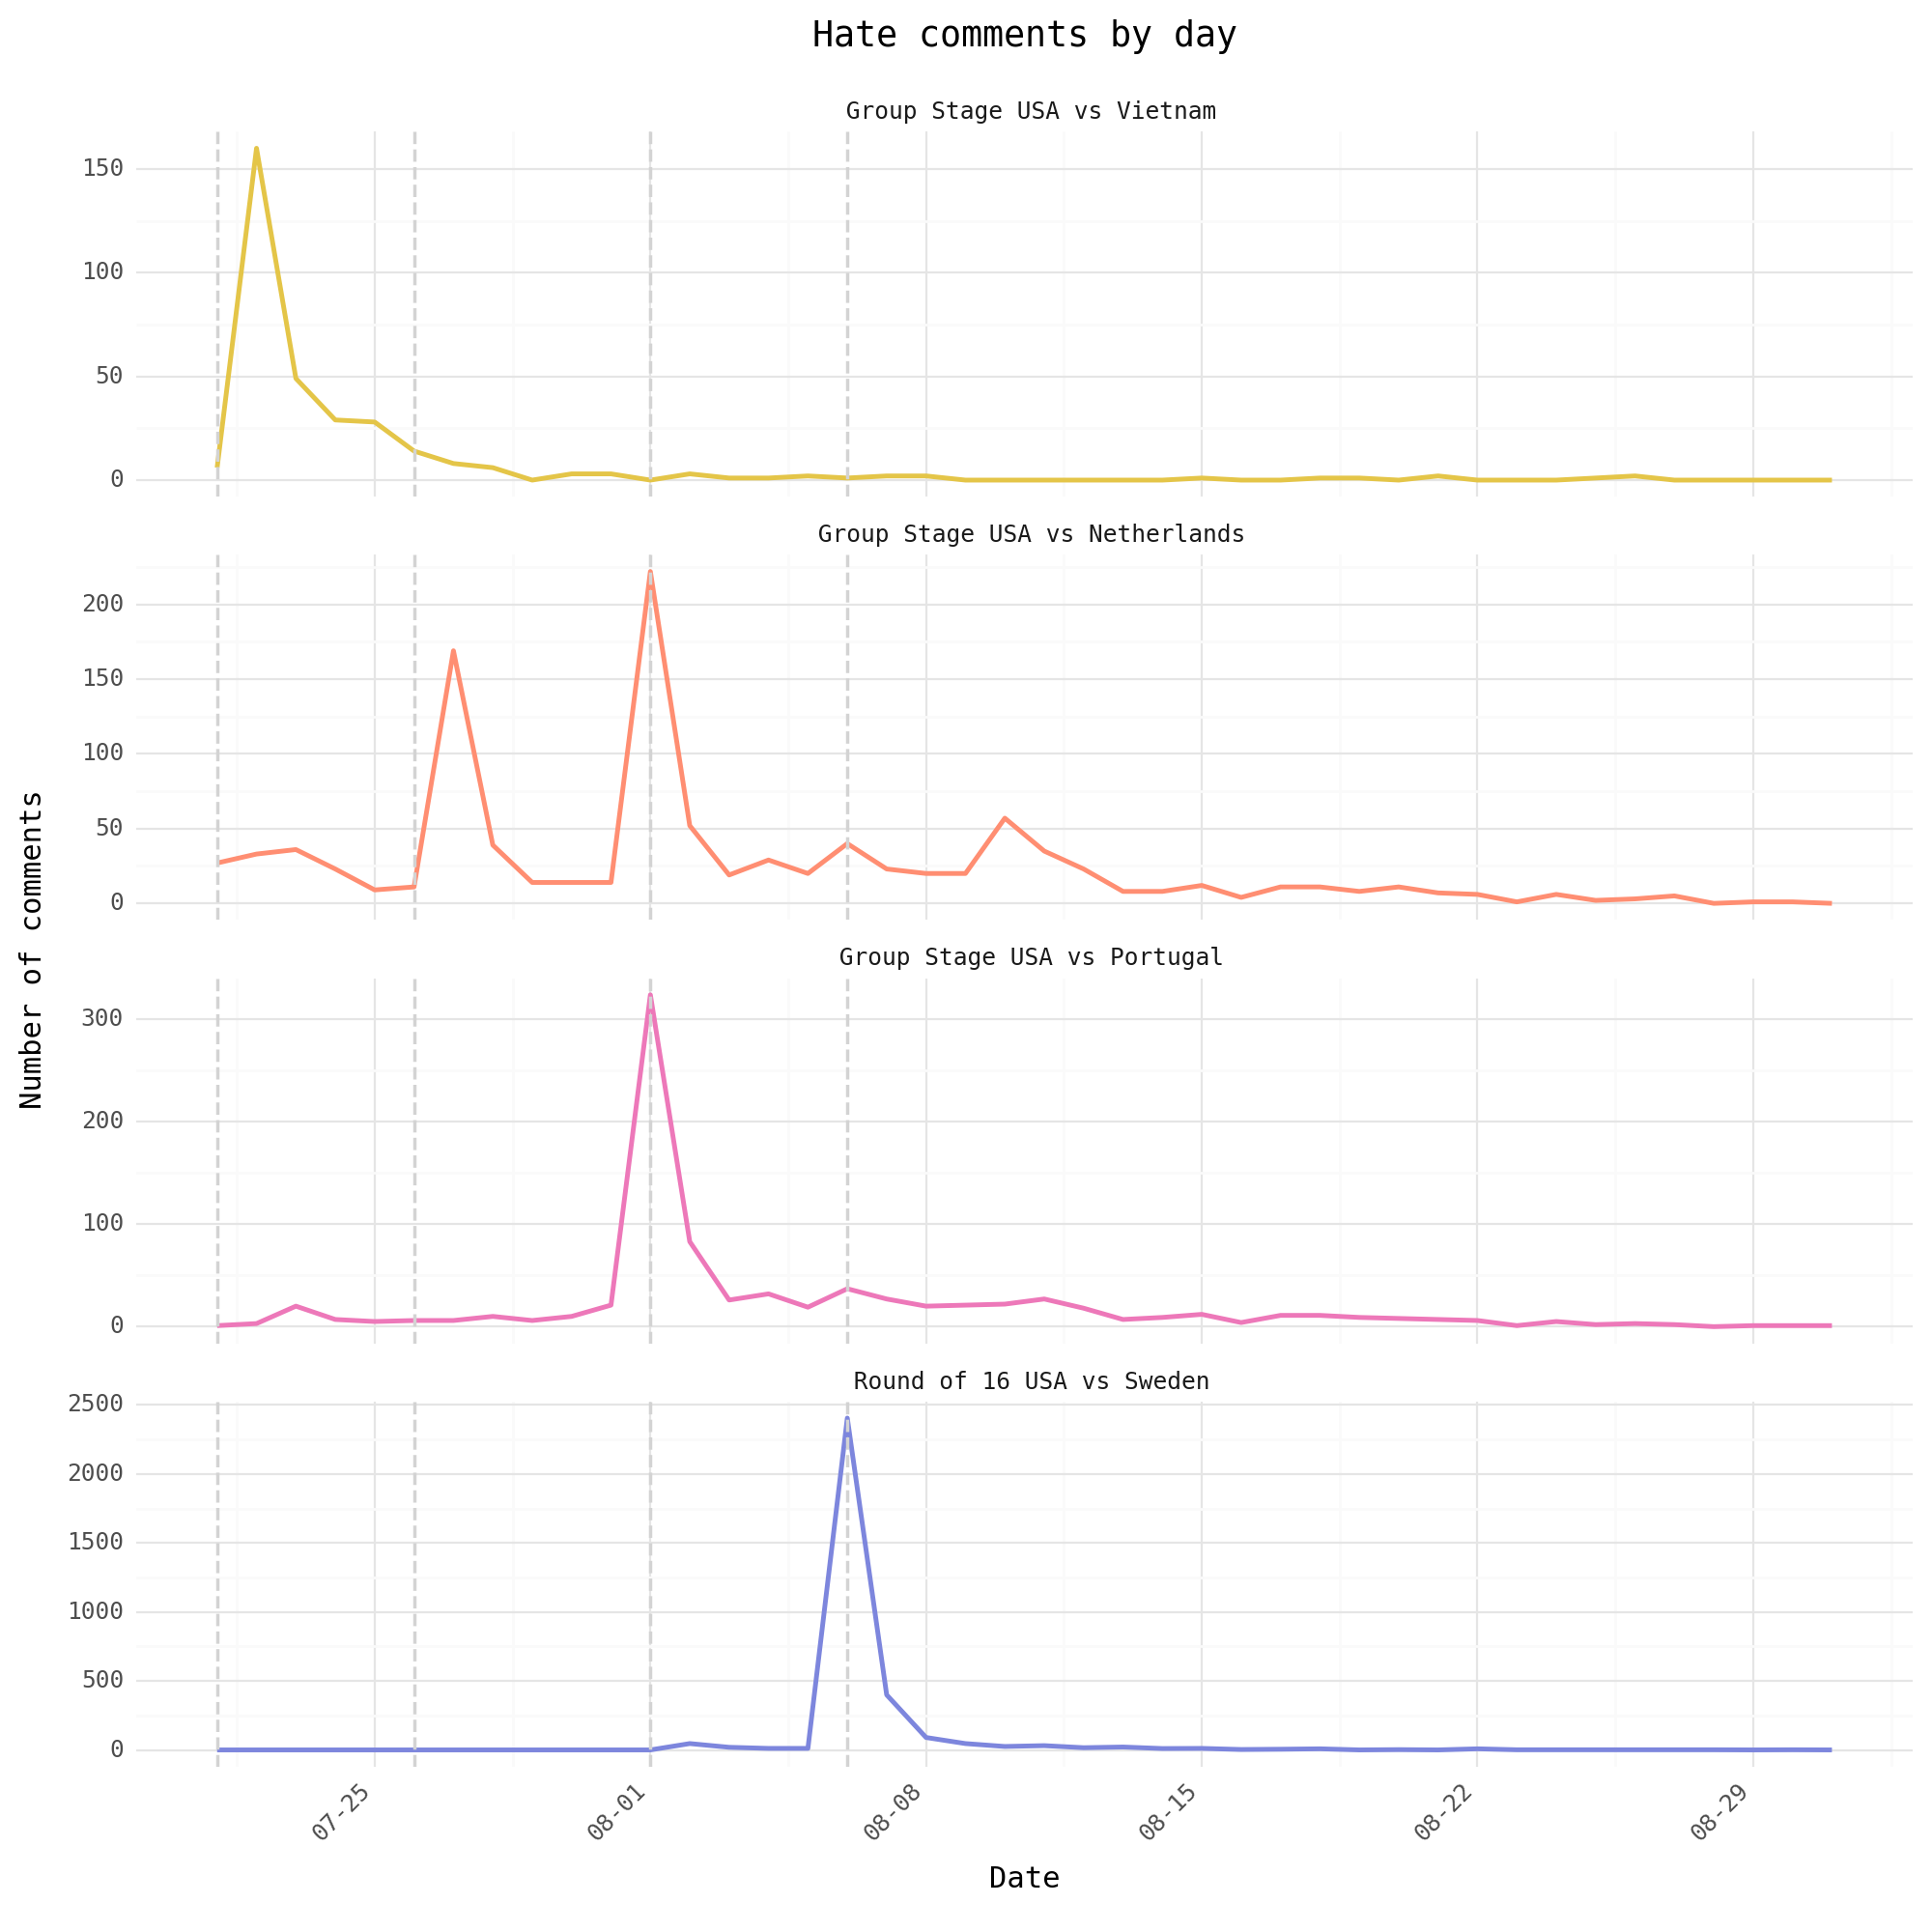

<Figure Size: (1000 x 1000)>

In [29]:
# set colour palettes
palette = ['#FFB6C1', '#FFD700', '#87CEEB', '#98FB98']
palette_2 = ['#e4c548', '#ff8e72', '#ed78b9', '#7d86dd']

# set reference dates for matches
reference_dates = ['2023-07-21', '2023-07-26', '2023-08-01', '2023-08-06']

# plot hate comments by day for each game
time_plot_line = (
    ggplot(hate_comments_day, aes(x='comment_date', y='total_comments', group='games_ordered', color= 'games_ordered')) +
    geom_line(size = 1) +
    geom_vline(xintercept=reference_dates, linetype='dashed', color='lightgray', size=0.7) + # add reference lines for match days
    scale_x_date(breaks='1 week', date_labels='%m-%d') +
    #scale_y_continuous(limits=(None, 2000)) +
    #expand_limits(y=0) +
    scale_color_manual(values=palette_2) +
    facet_wrap('~games_ordered', scales='free_y', ncol=1) +  # Single column for all games
    labs(title='Hate comments by day', x='Date', y='Number of comments') +
    guides(color=False) +
    theme_minimal() +
    theme(figure_size=(10, 10), panel_grid_major=None, axis_text_x=element_text(rotation=45, hjust=1, family = 'monospace'),
          text=element_text(family='monospace'), plot_title=element_text(hjust=0.5, family = 'monospace'))
)

time_plot_line

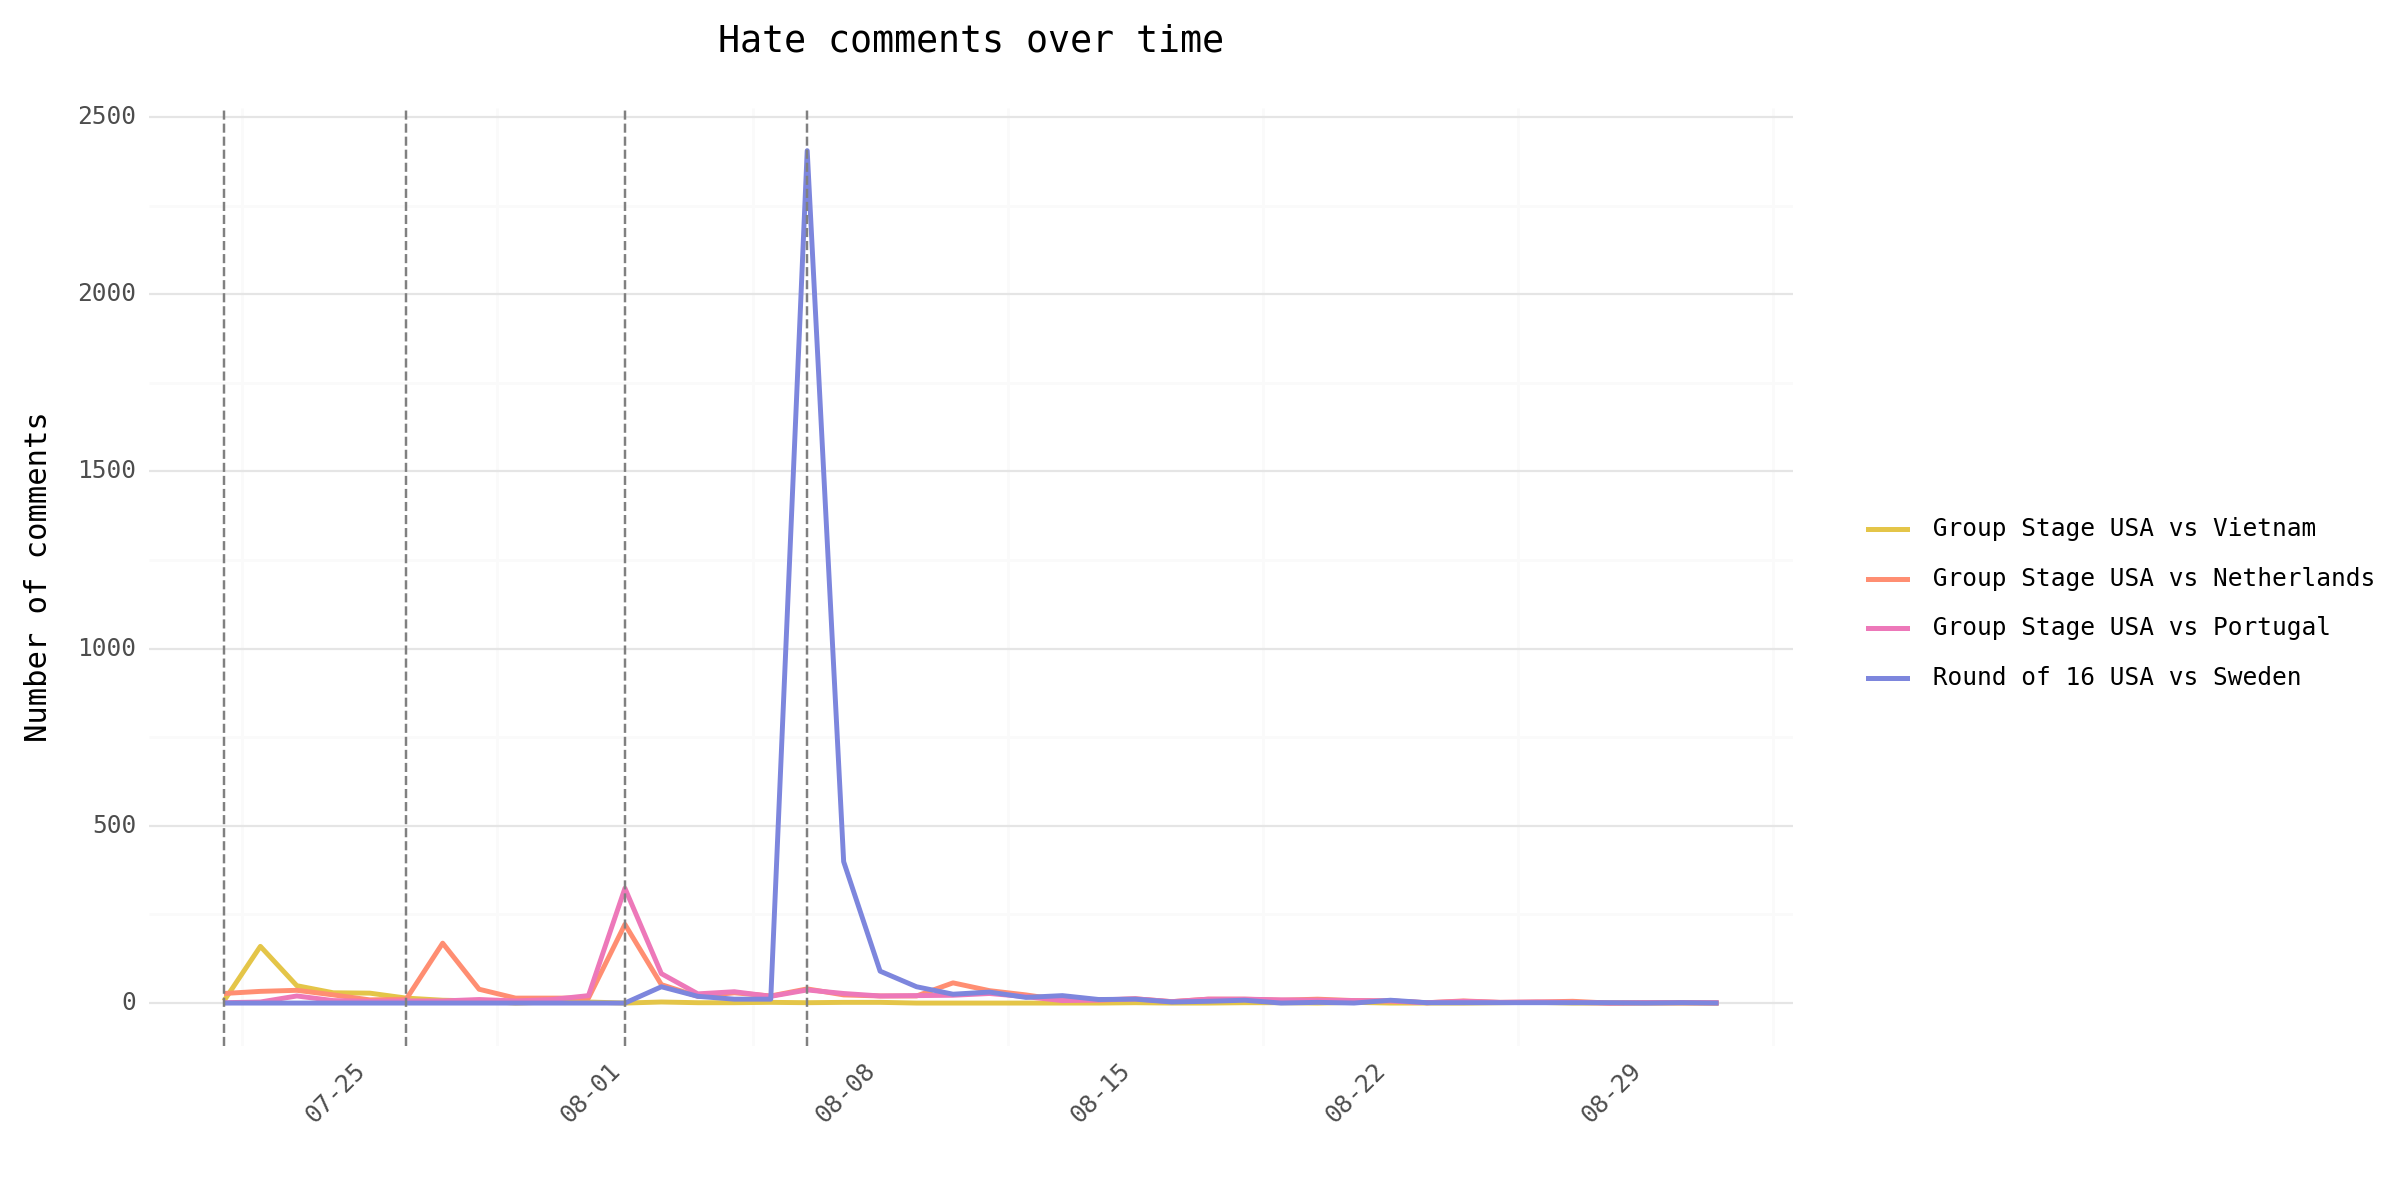

In [30]:
# Plot without facet
time_plot_line_2 = (
    ggplot(hate_comments_day, aes(x='comment_date', y='total_comments', group='games_ordered', color='games_ordered')) +
    geom_line(size=1) +
    geom_vline(xintercept=reference_dates, linetype='dashed', color='grey', size=0.5) +
    scale_x_date(breaks='1 week', date_labels='%m-%d') +
    scale_color_manual(values=palette_2) +
    labs(title='Hate comments over time', x = '', y='Number of comments') +
    guides(color=guide_legend(title='')) +
    theme_minimal() +
    theme(figure_size=(12, 6), axis_text_x=element_text(rotation=45, hjust=1, family = 'monospace'), text=element_text(family='monospace'),
          plot_title=element_text(hjust=0.5, family = 'monospace'), panel_grid_major_x= element_blank())
)
print(time_plot_line_2)

In [31]:
# create subset of df limited by time period
df_limited = df[(df['comment_date'] >= '2023-07-21') & (df['comment_date'] < '2023-09-01')]

# calculate share of hate comments by day
hate_comments_share = pd.crosstab(
    index=[df_limited['games_ordered'], df_limited['comment_date']],
    columns=df_limited['roberta_label'],
    normalize='index',
    margins=False
)

hate_comments_share = hate_comments_share.reset_index()

# rename cols
hate_comments_share.columns = ['games_ordered', 'comment_date', 'share_not_hate', 'share_hate']
hate_comments_share

games_ordered comment_date  share_not_hate  share_hate
0     Group Stage USA vs Vietnam   2023-07-21        0.923077    0.076923
1     Group Stage USA vs Vietnam   2023-07-22        0.885222    0.114778
2     Group Stage USA vs Vietnam   2023-07-23        0.845912    0.154088
3     Group Stage USA vs Vietnam   2023-07-24        0.848958    0.151042
4     Group Stage USA vs Vietnam   2023-07-25        0.814570    0.185430
..                           ...          ...             ...         ...
148    Round of 16 USA vs Sweden   2023-08-27        0.928571    0.071429
149    Round of 16 USA vs Sweden   2023-08-28        0.916667    0.083333
150    Round of 16 USA vs Sweden   2023-08-29        1.000000    0.000000
151    Round of 16 USA vs Sweden   2023-08-30        0.833333    0.166667
152    Round of 16 USA vs Sweden   2023-08-31        1.000000    0.000000

[153 rows x 4 columns]

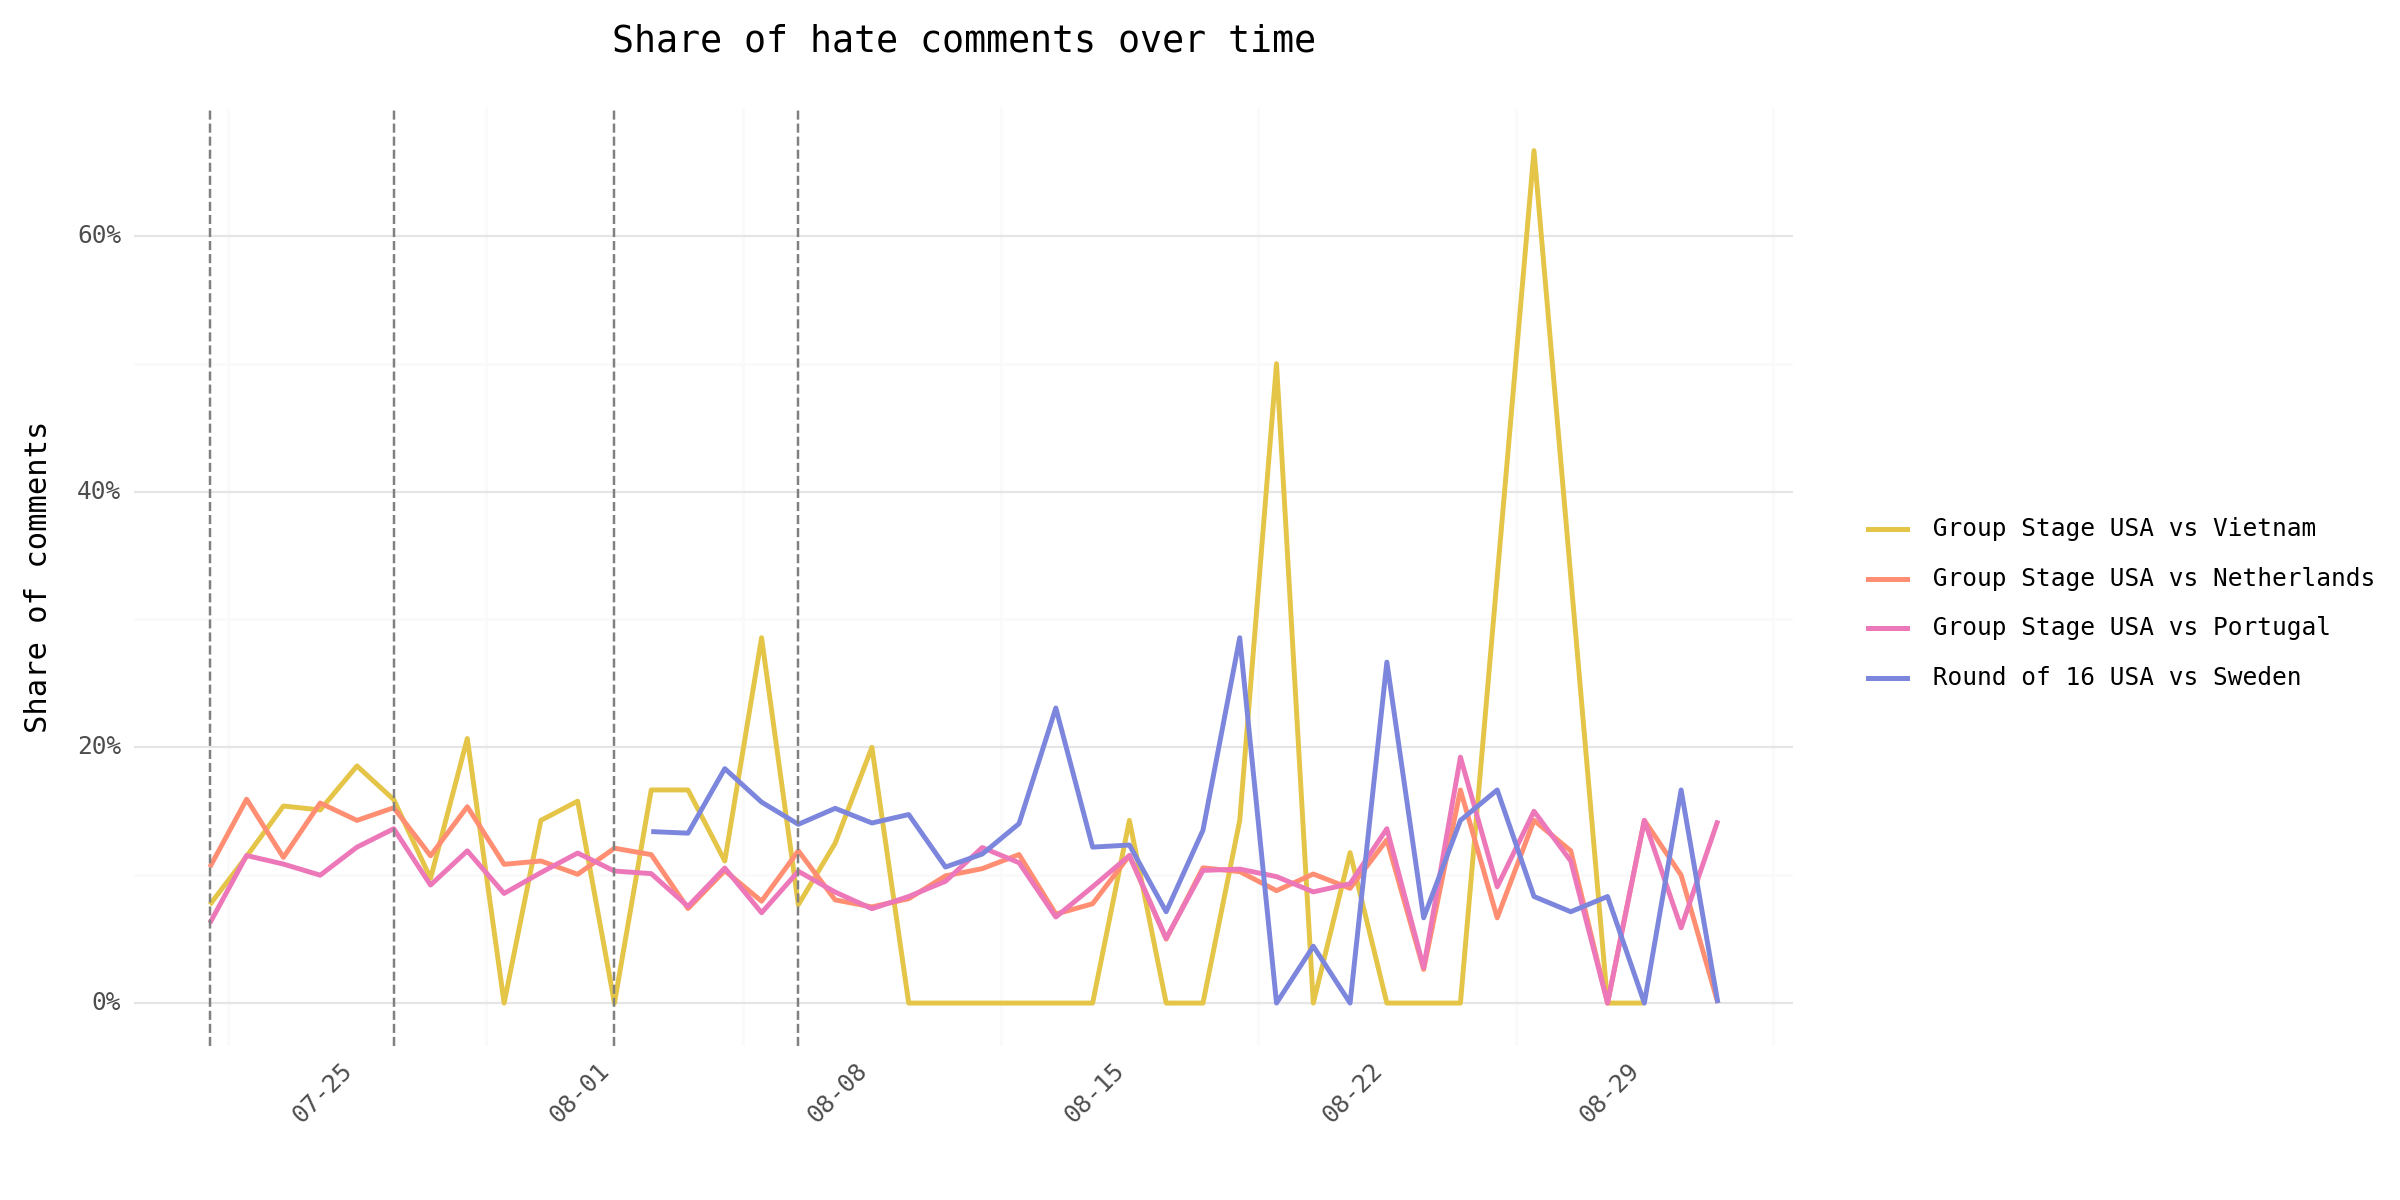

<Figure Size: (1200 x 600)>

In [32]:
from mizani.formatters import percent_format

# set palette
palette_3 = ['#e4c548', '#81aa67', '#ed78b9', '#7d86dd']

# Plot share of hate comments over time
time_plot_share = (
    ggplot(hate_comments_share, aes(x='comment_date', y='share_hate', group='games_ordered', color='games_ordered')) +
    geom_line(size=1) +
    geom_vline(xintercept= reference_dates, linetype='dashed', color='grey', size=0.5) + # add reference lines for matches
    scale_x_date(breaks='1 week', date_labels='%m-%d') +
    scale_y_continuous(labels=percent_format()) +
    scale_color_manual(values=palette_2) +
    labs(title='Share of hate comments over time', x = '', y='Share of comments') +
    guides(color=guide_legend(title='')) +
    theme_minimal() +
    theme(figure_size=(12, 6), axis_text_x=element_text(rotation=45, hjust=1, family = 'monospace'), text=element_text(family='monospace'),
          plot_title=element_text(hjust=0.5, family = 'monospace'), panel_grid_major_x= element_blank())
)
time_plot_share